<a href="https://colab.research.google.com/github/rachelhakes/Capstone-Project/blob/main/GRAD_CAM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# some_file.py
import sys

# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/content/gdrive/MyDrive/Colab Notebooks/LDL/code')

In [ ]:
import torch
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
from torch.nn import init
import torch.nn.functional as F
import numpy as np

# from torchvision.models import resnet152
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils import data
import cv2
# from torchvision.models import resnet101
# library
# standard library
import os, sys

# third-party library
# add log import
from math import log

import collections

from torchvision import transforms
from torch.utils.data import DataLoader
##### from the dataset folder
from dataset import dataset_processing
from timeit import default_timer as timer
##### from the utils folder
from utils.report import report_precision_se_sp_yi, report_mae_mse
from utils.utils import Logger, AverageMeter, time_to_str, weights_init
from utils.genLD import genLD
##### from the model folder
from model.resnet50 import *
import torch.backends.cudnn as cudnn
##### from the transforms folder
from transforms.affine_transforms import *
import time
import warnings
warnings.filterwarnings("ignore")
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import matplotlib.pyplot as plt

In [ ]:
# ResNet Class
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        # define the resnet152
        self.resnet = resnet152(pretrained=True)

        # isolate the feature blocks
        self.features = nn.Sequential(self.resnet.conv1,
                                      self.resnet.bn1,
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
                                      self.resnet.layer1,
                                      self.resnet.layer2,
                                      self.resnet.layer3,
                                      self.resnet.layer4)

        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # gradient placeholder
        self.gradient = None

    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad

    def get_gradient(self):
        return self.gradient

    def get_activations(self, x):
        return self.features(x)

    def forward(self, x):

        # extract the features
        x = self.features(x)

        # register the hook
        h = x.register_hook(self.activations_hook)

        # complete the forward pass
        x = self.avgpool(x)
        x = x.view((1, -1))
        x = self.classifier(x)

        return x


In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64

        def set_bn_fix(m):
            classname = m.__class__.__name__
            if classname.find('BatchNorm') != -1:
                for p in m.parameters(): p.requires_grad=False

        super(ResNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False),
            nn.BatchNorm2d(64).apply(set_bn_fix),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            self._make_layer(block, 64, layers[0]).apply(set_bn_fix),
            self._make_layer(block, 128, layers[1], stride=2).apply(set_bn_fix),
            self._make_layer(block, 256, layers[2], stride=2).apply(set_bn_fix),
            self._make_layer(block, 512, layers[3], stride=2).apply(set_bn_fix),
        )
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
        #                        bias=False)
        # self.bn1 = nn.BatchNorm2d(64)
        # self.relu = nn.ReLU(inplace=True)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # self.layer1 = self._make_layer(block, 64, layers[0])
        # self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        # self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        # gradient placeholder
        self.gradient = None

        #self.load_state_dict(model_zoo.load_url(model_urls['resnet101']))

        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        #         m.weight.data.normal_(0, math.sqrt(2. / n))
        #     elif isinstance(m, nn.BatchNorm2d):
        #         m.weight.data.fill_(1)
        #         m.bias.data.zero_()

        # self.avgpool = nn.Sequential(nn.AdaptiveAvgPool2d(4), nn.AdaptiveMaxPool2d(1))
        # self.fc.apply(weights_init)
        #

        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Linear(512 * block.expansion, 4)
        # self.fc = nn.Sequential(nn.Linear(2048, 512),
        #                         nn.ReLU(inplace=True),
        #                         nn.Dropout(p=0.5),
        #                         nn.Linear(512, 4))
        self.fc.apply(weights_init)

        self.counting = nn.Linear(512 * block.expansion, 65)
        # self.counting = nn.Sequential(nn.Linear(2048, 512),
        #                               nn.ReLU(inplace=True),
        #                               nn.Dropout(p=0.5),
        #                               nn.Linear(512, 65))
        self.counting.apply(weights_init)


        # self.bn1.apply(set_bn_fix)
        # self.layer1.apply(set_bn_fix)
        # self.layer2.apply(set_bn_fix)
        # self.layer3.apply(set_bn_fix)
        # self.layer4.apply(set_bn_fix)

        # self.conv2 = nn.Sequential(nn.Conv2d(2048, 2048, kernel_size=3, stride=2, padding=1, bias=True),
        #                            nn.ReLU(inplace=True))
        # self.conv2.apply(weights_init)

    def activations_hook(self, grad):
        self.gradient = grad

    def get_gradient(self):
        return self.gradient

    def get_activations(self, x):
        return self.features(x)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x, x_new):

        # extract the features
        x = self.features(x)

        # register the hook
        if x.requires_grad:
          h = x.register_hook(self.activations_hook)

        # complete the forward pass
        # x = self.avgpool(x)
        # x = x.view((1, -1))
        # x = self.classifier(x)

        # return x




        # complete the forward pass
        x = self.avgpool(x)
        x = x.view((x.size(0), -1))
        cls = self.fc(x)
        cou = self.counting(x)

        cls = F.softmax(cls) + 1e-4
        cou = F.softmax(cou) + 1e-4
        '''
        if batch_size % 16 == 0 and self.training == True:
            for i in range(batch_size):
                if i == 0:
                    temp = x[x_new[0]].view(1, 4, 2048, 7, 7)
                else:
                    temp = torch.cat((temp, x[x_new[i]].view(1, 4, 2048, 7, 7)), 0)
            temp = temp.view(batch_size, 2048, 14, 14)
            x_new = F.adaptive_max_pool2d(temp, 7)
            # x_new = self.conv2(temp)
            x = torch.cat((x, x_new))
            # print('te')
        '''
        # if batch_size % 16 == 0 and self.training == True:
        #     x_new = F.adaptive_max_pool2d(x[x_new].view(len(x_new), 2048, 14, 14), 7)
        #     x = torch.cat((x, x_new))

        # x = F.adaptive_max_pool2d(x, 4)  # .....

        # x = self.avgpool(x)
        # x = x.view(x.size(0), -1)

        # cls = self.fc(x)
        # cou = self.counting(x)

        # cls = F.softmax(cls) + 1e-4
        # cou = F.softmax(cou) + 1e-4

        cou2cls = torch.stack((torch.sum(cou[:, :5], 1), torch.sum(cou[:, 5:20], 1), torch.sum(cou[:, 20:50], 1),
                               torch.sum(cou[:, 50:], 1)), 1)
        # cou2cls = torch.log(cou2cls)

        # Exception
        # cou2cou = torch.sum(cou * torch.from_numpy(np.array(range(1, 66))).float().cuda(), 1)
         # register the hook
        # h = x.register_hook(self.activations_hook)

        return cls, cou, cou2cls

In [ ]:
def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    #if pretrained:
        #model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [ ]:
def criterion(lesions_num):
    '''
    Function serves as a label encoder to put each picture into one of
    four classes based on the number of lesions on the persons face.
    ------
    INPUT: lesions_num, integer, greater than or equal to 0
    -----
    OUTPUT: 0, 1, 2, or 3 based on the number of lesions in the picture.
    '''
    if lesions_num <= 5:
        return 0
    elif lesions_num <= 20:
        return 1
    elif lesions_num <= 50:
        return 2
    else:
        return 3

In [ ]:
# Hyper Parameters
BATCH_SIZE = 32
BATCH_SIZE_TEST = 20
LR = 0.001              # learning rate
NUM_WORKERS = 12
##### classes will be mild, moderate, severe and very severe
NUM_CLASSES = 4
##### original file path
#LOG_FILE_NAME = './logs/log_' + time.strftime("%Y-%m-%d_%H:%M:%S", time.localtime()) + '.log'
##### correct file path from my drive
LOG_FILE_NAME = '/content/gdrive/MyDrive/Colab Notebooks/logs' + time.strftime("%Y-%m-%d_%H:%M:%S", time.localtime()) + '.log'
#lr_steps = [30, 60, 90, 120]
#### change to :
#lr_steps = [15, 30, 45, 60]
#OR
lr_steps = [10, 20, 30, 40]
## if problems with division then go to 30, 60

np.random.seed(42)

In [ ]:
DATA_PATH = '/content/gdrive/MyDrive/Colab Notebooks/data/JPEGImages'
##### logging tracks events that happen when some software runs
##### helps determine the cause of the problem if something goes wrong
log = Logger()
##### mode a means open for writing -- file is created if it doesn't exist
##### appends new information if the file is already in existence
log.open(LOG_FILE_NAME, mode="a")
cross_val_index = '0'
TRAIN_FILE = '/content/gdrive/MyDrive/Colab Notebooks/data/LDL/Main/NNEW_trainval_'  + cross_val_index + '.txt'
TEST_FILE = '/content/gdrive/MyDrive/Colab Notebooks/data/LDL/Main/NNEW_test_' + cross_val_index + '.txt'

In [ ]:



normalize = transforms.Normalize(mean=[0.45815152, 0.361242, 0.29348266],
                                     std=[0.2814769, 0.226306, 0.20132513])
dset_train = dataset_processing.DatasetProcessing(
        DATA_PATH, TRAIN_FILE, transform=transforms.Compose([
                ##### Scale does not work -- changed to Resize
                #transforms.Scale((256, 256)),
                transforms.Resize((256, 256)),
                transforms.RandomCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                RandomRotate(rotation_range=20),
                normalize,
            ]))

dset_test = dataset_processing.DatasetProcessing(
        DATA_PATH, TEST_FILE, transform=transforms.Compose([
                ##### Scale does not work -- changed to Resize
                #transforms.Scale((224, 224)),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                normalize,
            ]))

train_loader = DataLoader(dset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              pin_memory=True)

test_loader = DataLoader(dset_test,
                             batch_size=1,
                             shuffle=False,
                             num_workers=NUM_WORKERS,
                             pin_memory=True)



In [ ]:
state_dict = torch.load("/content/gdrive/MyDrive/Colab Notebooks/models/model_resnet101-all5_40epoch.pth")
from collections import OrderedDict
new_state_dict = OrderedDict()
new_keys = list(state_dict.keys())[:-2]
# new_keys
for k in new_keys:
  new_state_dict[k] = state_dict[k]

In [ ]:
torch.save(new_state_dict, '/content/gdrive/MyDrive/Colab Notebooks/models/model_resnet101-new.pth')

In [ ]:
# cp_path = '/content/gdrive/MyDrive/Colab Notebooks/models/model_resnet101-all5_40epoch.pth'
cnn = resnet152().cuda()
# cnn.load_state_dict(torch.load(cp_path))

In [ ]:
cnn

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
_ = cnn.eval()

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
for step, img in enumerate(test_loader):
  pred = resnet(img[0]) # test_x
  test_fn = test_fn = all_test_files[step]
  ##### paste from your pretrained code from line
  '''
  pred.argmax(dim=1)
  '''

In [ ]:
for step, (test_x, test_y, test_l) in enumerate(test_loader): # just use the loop
  # cnn.zero_grad()
  test_x = test_x.cuda()
  test_y = test_y.cuda()
  # print(test_x)
  # print(test_y)
  # cnn.fc.register_forward_hook(get_activation('fc'))
  input = torch.autograd.Variable(test_x, requires_grad=True)
  cls, cou, cou2cls = cnn(input)
  # print(activation['fc'])
  break

tensor([[-0.0005,  0.0010, -0.0003,  0.0002]], device='cuda:0')


In [ ]:
kl_loss_1 = nn.KLDivLoss().cuda()
sigma=30 * 0.1
test_l = test_l - 1
ld = genLD(test_l, sigma, 'klloss', 65)
ld_4 = np.vstack((np.sum(ld[:, :5], 1), np.sum(ld[:, 5:20], 1), np.sum(ld[:, 20:50], 1), np.sum(ld[:, 50:], 1))).transpose()
ld_4 = torch.from_numpy(ld_4).cuda().float()
loss_cls = kl_loss_1(torch.log(cls), ld_4) * 4.0
cnn.zero_grad()           # clear gradients for this training step
loss_cls.backward()
input.grad

tensor([[[[-2.3979e-07,  5.6893e-07, -9.3353e-07,  ..., -6.5606e-09,
           -6.9683e-10,  9.2065e-10],
          [-6.2963e-07, -1.1458e-06, -6.3870e-08,  ...,  1.1900e-09,
            1.7090e-10, -1.9214e-09],
          [ 8.8348e-09,  1.0423e-06, -8.7965e-07,  ...,  4.8032e-09,
            1.7679e-10,  1.6897e-09],
          ...,
          [ 1.3827e-09, -6.7273e-11,  1.8111e-09,  ...,  7.1708e-10,
           -1.5442e-10, -1.0317e-10],
          [ 1.2826e-10, -3.3545e-10, -6.3751e-10,  ...,  3.0786e-10,
           -6.4698e-11,  3.4132e-10],
          [ 1.6935e-10, -4.8910e-10,  1.0328e-09,  ..., -3.6246e-11,
           -2.6074e-10, -1.5128e-10]],

         [[-1.5425e-08, -2.2949e-07, -1.9876e-07,  ..., -3.3834e-09,
           -1.2103e-09,  5.4039e-10],
          [-6.3761e-07, -4.9832e-07,  1.3283e-06,  ..., -4.9900e-09,
           -3.4038e-09, -1.9497e-10],
          [ 1.5151e-07, -4.8849e-07,  4.5381e-07,  ...,  1.7340e-09,
           -1.3292e-09,  2.8475e-10],
          ...,
     

In [ ]:
gradients = input.grad

pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
pooled_gradients

tensor([-6.5990e-09,  3.0665e-09, -1.6394e-09], device='cuda:0')

tensor([[[[-0.0164, -0.0377, -0.0426,  ..., -0.0337, -0.0405, -0.0387],
          [-0.0110, -0.0651, -0.0642,  ..., -0.0205, -0.0558, -0.0612],
          [-0.0121, -0.0727, -0.0585,  ..., -0.0561, -0.0566, -0.0612],
          ...,
          [-0.0112, -0.0693, -0.0692,  ..., -0.0692, -0.0692, -0.0681],
          [-0.0112, -0.0694, -0.0692,  ..., -0.0692, -0.0692, -0.0681],
          [-0.0104, -0.0693, -0.0690,  ..., -0.0690, -0.0690, -0.0677]],

         [[-0.0363, -0.0004, -0.0077,  ..., -0.0086, -0.0095, -0.0037],
          [-0.0880, -0.0437, -0.0464,  ..., -0.0477, -0.0402, -0.0425],
          [-0.0879, -0.0603, -0.0759,  ..., -0.0640, -0.0580, -0.0436],
          ...,
          [-0.0944, -0.0449, -0.0449,  ..., -0.0449, -0.0449, -0.0434],
          [-0.0944, -0.0448, -0.0448,  ..., -0.0448, -0.0448, -0.0433],
          [-0.0942, -0.0450, -0.0454,  ..., -0.0454, -0.0454, -0.0443]],

         [[-0.0059,  0.0135,  0.0153,  ...,  0.0112,  0.0097,  0.0123],
          [-0.0485, -0.0073, -

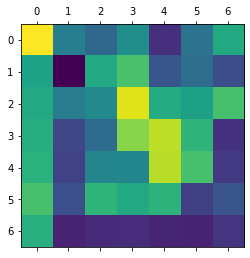

In [ ]:
# h1 = cnn.avgpool.register_forward_hook(get_activation('avgpool'))
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
h0 = cnn.maxpool.register_forward_hook(get_activation('maxpool'))
h3 = cnn.layer3[0].downsample[0].register_forward_hook(get_activation('layer3'))
h4 = cnn.layer4[0].downsample[0].register_forward_hook(get_activation('layer4'))
h2 = cnn.layer2[0].downsample[0].register_forward_hook(get_activation('layer2'))
h1 = cnn.layer1[0].downsample[0].register_forward_hook(get_activation('layer1'))
cls, cou, cou2cls = cnn(test_x)

print(activation['layer3'])

# dx = test_x.grad
# print("x.grad :", dx)
activations = activation['layer4'].detach()
for i in range(3):
    activations[:, i, :, :] *= pooled_gradients[i]
# activations = activation['avgpool'].detach()
print(activations.shape)
heatmap = torch.mean(activations, dim=1).squeeze().cpu().data
print(heatmap.shape)


# draw the heatmap
plt.matshow(heatmap.squeeze())

# make the heatmap to be a numpy array
heatmap = heatmap.numpy()


In [ ]:
all_test_files = [] # is list of test file names from the txt file

In [ ]:
print(heatmap)

[[ 3.0669975e-04 -1.4582388e-04 -2.1848711e-04 -9.1322174e-05
  -3.7804584e-04 -1.8334007e-04 -2.9066287e-06]
 [-2.6706257e-05 -4.8552375e-04 -1.1447701e-06  7.8490266e-05
  -2.7312964e-04 -2.0162413e-04 -2.9656285e-04]
 [-6.9657981e-06 -1.5288751e-04 -1.1383099e-04  2.6790414e-04
   1.3292301e-06 -3.9416074e-05  7.6214550e-05]
 [ 9.0869144e-06 -3.1241699e-04 -2.0857033e-04  1.6316923e-04
   2.2739821e-04  2.9826435e-05 -3.7041961e-04]
 [ 1.9978324e-05 -3.3132423e-04 -1.2614003e-04 -1.2179156e-04
   2.2033745e-04  7.6040509e-05 -3.5110262e-04]
 [ 7.5044343e-05 -2.9328273e-04  3.2423792e-05 -5.1656389e-06
   2.7559407e-05 -3.3455328e-04 -2.7797872e-04]
 [ 9.7420998e-06 -4.1038898e-04 -3.8769090e-04 -3.8641170e-04
  -4.0267356e-04 -4.0552072e-04 -3.6386924e-04]]


True

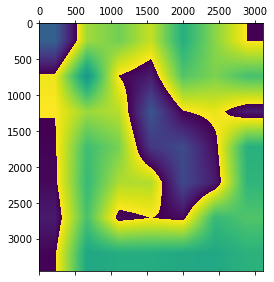

In [ ]:
# interpolate the heatmap
#img = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/data/JPEGImages/levle0_451.jpg') #### change this to the first test file
base_dir = '/content/gdrive/MyDrive/Colab Notebooks/data/JPEGImages/' #### change to your image folder
test_fn = all_test_files[step]
test_path = base_dir + test_fn
img = cv2.imread(test_path)
model_name = ''
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap *1000)
plt.matshow(heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * .8 + img
cv2.imwrite(test_fn+model_name+'.jpg', superimposed_img)